In [4]:
import numpy as np
import abc
import os, sys
import hashlib
from os.path import join as opj

import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.rcParams.update({'font.size': 18})
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import healpy as hp

import plancklens
from plancklens import utils

from lenscarf.iterators.statics import rec

from component_separation.cs_util import Config

from lenscarf.lerepi.visalot import plot_helper as ph
from lenscarf.lerepi.visalot.plot_helper import colorscale, bandpass_alms, get_ms

csu = Config('Planck')
colors = csu.CB_color_cycle
colors_lt = csu.CB_color_cycle_lighter

nside = 2048
lmax_cl = 2048
lmax_plot = 195
lmax_qlm = 2500
lmax_mask = 4096

bk14_edges = np.array([2,55,90,125,160,195,230,265,300, 500, 700, 1000, 1500, 2000, 3000, 4000, 5000]) # BK14 is [ 55  90 125 160 195 230 265 300], from bk14 = h5py.File('/global/homes/s/sebibel/notebooks/CMBS4/datasharing/likedata_BK14.mat', 'r')['likedata']['lval'][0,:]
ioreco_edges = np.array([2,30,200, 300, 500, 700, 1000, 1500, 2000, 3000, 4000, 5000])
cmbs4_edges = np.array([2, 30, 60, 90, 120, 150, 180, 200, 300, 500, 700, 1000, 1500, 2000, 3000, 4000, 5000])

ll = np.arange(0,lmax_plot+1,1)
binspace = 5
scale_uk = (2 * ll + 1) * ll**2 * (ll + 1)**2
scale_ps = ll*(ll+1)/(2*np.pi)
label_scale_ps = r'$\frac{\ell(\ell+1)}{2 \pi}$'
label_scale_lp = r'$\frac{\ell^2(\ell+1)^2}{2 \pi}$'
scale_lp = ll**2 * (ll + 1)**2 * 1e7 / (2 * np.pi)

psl = r'$\frac{l(l+1)}{2\pi}C_\ell \/ [\mu K^2]$'

beam = 2.3
lmax_transf = 4000
transf = hp.gauss_beam(beam / 180. / 60. * np.pi, lmax=lmax_transf)

cls_path = opj(os.path.dirname(plancklens.__file__), 'data', 'cls')
cls_len = utils.camb_clfile(opj(cls_path, 'FFP10_wdipole_lensedCls.dat'))
clc_templ = cls_len['bb']

# Meanfields

In [11]:
iterations = np.arange(0,12+1)
_simidx = 0
mf_lms = np.array([np.load("/global/cscratch1/sd/sebibel/cmbs4/08b_07_OBD_MF100_example/p_p_sim%04d/wflms/btempl_p%03d_e%03d_lmax1024.npy"%(_simidx, it, it)) for it in iterations])
mf_lms_QEmfvar = np.array([np.load("/global/cscratch1/sd/sebibel/cmbs4/08b_07_OBD_MF100_example/p_p_sim%04dmf00/wflms/btempl_p%03d_e%03d_lmax1024.npy"%(_simidx, it, it)) for it in iterations])
mf_lms_MAPmfvar = np.array([mf_lms[0]]+[np.load("/global/cscratch1/sd/sebibel/cmbs4/08b_07_OBD_MF100_example/p_p_sim%04d/wflms/btempl_p%03d_e%03d_lmax1024_dlmmod.npy"%(_simidx, it, it)) for it in iterations[1:]])

# mf0 = np.load('/global/cscratch1/sd/sebibel/cmbs4/08b_00_OBD_MF100_example/p_p_sim0050/mf.npy')
plms = rec.load_plms('/global/cscratch1/sd/sebibel/cmbs4/08b_07_OBD_MF100_example/p_p_sim%04d/'%_simidx, iterations)

In [ ]:
mf_maps = np.array([hp.alm2map(btemp, nside=2048) for btemp in mf_lms])
mf_QEmod_maps = np.array([hp.alm2map(btemp, nside=2048) for btemp in mf_lms_QEmfvar])
mf_MAPmod_maps = np.array([hp.alm2map(btemp, nside=2048) for btemp in mf_lms_MAPmfvar])

In [ ]:
for mf_map in mf_maps:
    hp.cartview(mf_map, lonra=[0,70], latra=[-70,-30])

In [ ]:
for mf_map in mf_QEmod_maps:
    hp.cartview(mf_map, lonra=[0,70], latra=[-70,-30])

In [ ]:
for mf_map, mf_mod_map in zip(mf_maps, mf_QEmod_maps):
    hp.cartview(mf_map-mf_mod_map, lonra=[0,70], latra=[-70,-30], norm='hist')

In [21]:
mf_cls = np.array([hp.alm2cl(mf) for mf in mf_lms])
mf_cls_QEmfvar = np.array([hp.alm2cl(mf) for mf in mf_lms_QEmfvar])
mf_cls_MAPmfvar = np.array([hp.alm2cl(mf) for mf in mf_lms_MAPmfvar])

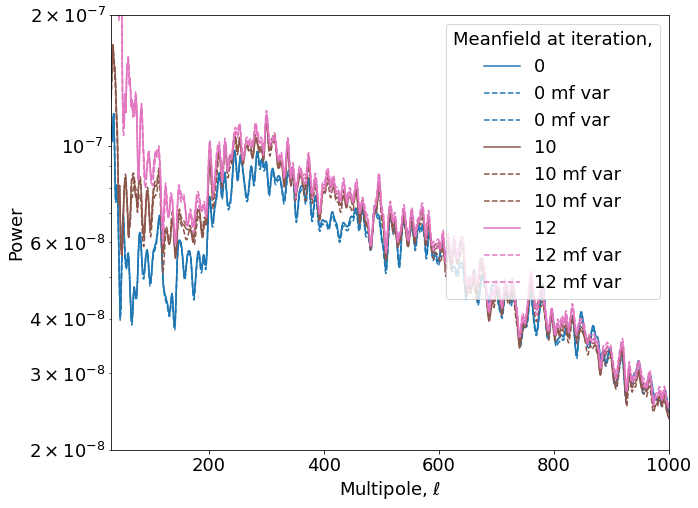

In [16]:
fig = plt.figure(figsize=(10,8))
shift = 0
cmap = matplotlib.cm.get_cmap('tab20')
rgba = cmap(np.arange(0,1,1/20))
for speci, (mf_cl, mf_cl_Qmfvar, mf_cl_Mmfvar) in enumerate(zip(mf_cls, mf_cls_QEmfvar, mf_cls_MAPmfvar)):
    if speci in [0,10,12]:
        plt.plot(mf_cl, label=speci, color=rgba[speci])
        plt.plot(mf_cl_Qmfvar, label=str(speci)+' mf var', color=rgba[speci], ls='--')
        plt.plot(mf_cl_Mmfvar, label=str(speci)+' mf var', color=rgba[speci], ls='--')
        # plt.plot(hp.alm2cl(plms[speci]), color=rgba[speci], lw=3, ls = '--')
plt.legend(title='Meanfield at iteration,')
# plt.xscale('log')
plt.yscale('log')
plt.xlim(30,1000)
plt.ylim(2e-8,2e-7)
plt.xlabel('Multipole, $\ell$')
plt.ylabel('Power')
sims_str = 'cmbs4/08b/caterinaILC_May12'
plt.savefig('/global/homes/s/sebibel/plots/'+sims_str+'/Cl_mf_mfvar.pdf', bbox_inches='tight')

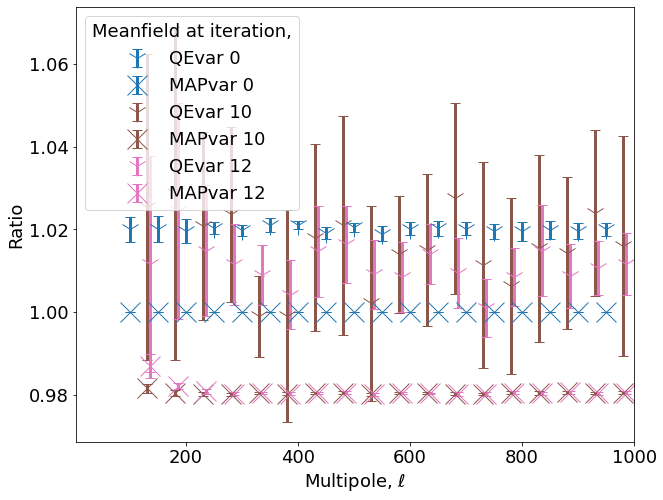

In [25]:

fig = plt.figure(figsize=(10,8))
shift = 0
cmap = matplotlib.cm.get_cmap('tab20')
rgba = cmap(np.arange(0,1,1/20))
edges = cmbs4_edges
edges_center = (edges[1:]+edges[:-1])/2
for speci, (mf_cl, mf_cl_Qmfvar, mf_cl_Mmfvar) in enumerate(zip(mf_cls, mf_cls_QEmfvar, mf_cls_MAPmfvar)):
    if speci in [0,10,12]:
        # if speci == 0:
        #     shift = 0
        # else:
        #     shift = 0.02
        mean, std = np.array([np.mean((mf_cl/mf_cl_Qmfvar)[(n-1)*50:n*50])+shift for n in range(20)]), np.array([np.std((mf_cl/mf_cl_Qmfvar)[(n-1)*50:n*50]) for n in range(20)])
        plt.errorbar(np.arange(0,1000,1000/20)+speci*3, mean, yerr=std, label="QEvar "+str(speci), color=rgba[speci], lw=3, ls='', capsize=5, ms=20, fmt='1')
        mean, std = np.array([np.mean((mf_cl/mf_cl_Mmfvar)[(n-1)*50:n*50])+shift for n in range(20)]), np.array([np.std((mf_cl/mf_cl_Mmfvar)[(n-1)*50:n*50]) for n in range(20)])
        plt.errorbar(np.arange(0,1000,1000/20)+speci*3, mean, yerr=std, label="MAPvar "+str(speci), color=rgba[speci], lw=3, ls='', capsize=5, ms=20, fmt='x')
        # plt.plot(hp.alm2cl(plms[speci]), color=rgba[speci], lw=3, ls = '--')
plt.legend(title='Meanfield at iteration,')
plt.xlim(4,1000)
plt.xlabel('Multipole, $\ell$')
plt.ylabel('Ratio')
sims_str = 'cmbs4/08b/caterinaILC_May12'
plt.savefig('/global/homes/s/sebibel/plots/'+sims_str+'/Cl_mf_mfvar_ratio.pdf', bbox_inches='tight')

In [ ]:
dlmmod_map = hp.alm2map(dlmmod, nside=2048)
mf1_map = hp.alm2map(mf1, nside=2048)
plm12_map = hp.alm2map(plm12[0], nside=2048)
mf1_map = hp.alm2map(mf1, nside=2048)
mf2_map = hp.alm2map(mf2, nside=2048)
hp.mollview(mf1_map, norm='hist')
hp.mollview(mf2_map, norm='hist')
hp.mollview(mf2_map-mf1_map, norm='hist')
mf1_cl = hp.alm2cl(mf1)
mf2_cl = hp.alm2cl(mf2)
mf2_clX = hp.alm2cl(mf1, alms2=mf2)
# plt.plot(mf1_cl/mf2_cl)
plt.plot(mf1_cl)
plt.plot(mf2_cl)
plt.plot(mf2_clX)
# plt.yscale('log')
# plt.ylim(1e16,1e18)
plt.plot(mf2_clX**2/(mf1_cl*mf2_cl), label='Meanfield Correlation')
plt.legend()
plt.xlabel('Multipole')
plt.ylabel('$ \dfrac{C^{mf00,mf07}}{C^{mf00,mf00}C^{mf07,mf07}}$')

# B template

In [ ]:
mf1 = np.load('/global/cscratch1/sd/sebibel/cmbs4/08b_07_OBD_MF100_example/p_p_sim0050/mf.npy')
mf2 = np.load('/global/cscratch1/sd/sebibel/cmbs4/08b_07_OBD_MF100_example/p_p_sim0050mf00/mf.npy')
btemp1 = np.load('/global/cscratch1/sd/sebibel/cmbs4/08b_00_OBD_MF100_example/p_p_sim0000/wflms/btempl_p012_e012_lmax1024.npy')
btemp_mod = np.load('/global/cscratch1/sd/sebibel/cmbs4/08b_00_OBD_MF100_example/p_p_sim0000/wflms/btempl_p012_e012_lmax1024_dlmmod.npy')
btemp1_map = hp.alm2map(btemp1, nside=2048)
btempmod_map = hp.alm2map(btemp_mod, nside=2048)
btemp1_cl = hp.alm2cl(btemp1)
btempmod_cl = hp.alm2cl(btemp_mod)
plt.plot(btemp1_cl/btempmod_cl)
plt.hlines(1,0,1000)
# plt.plot()
# plt.yscale('log')

In [ ]:

iterations = np.arange(0,12+1)
_simidx = 2
btemps = np.array([np.load("/global/cscratch1/sd/sebibel/cmbs4/08b_00_OBD_MF100_example/p_p_sim%04d/wflms/btempl_p%03d_e%03d_lmax1024.npy"%(_simidx, it, it)) for it in iterations])
btemps_mod = np.array([np.load("/global/cscratch1/sd/sebibel/cmbs4/08b_00_OBD_MF100_example/p_p_sim%04d/wflms/btempl_p%03d_e%03d_lmax1024_dlmmod.npy"%(_simidx, it, it)) for it in iterations])
btemp_diff_map = np.array([hp.alm2map(ph.bandpass_alms(btemp-btemp_mod,200,1000), nside=2048) for btemp, btemp_mod in zip(btemps,btemps_mod)])
btemp_maps = np.array([hp.alm2map(btemp, nside=2048) for btemp in btemps])
btemp_mod_maps = np.array([hp.alm2map(btemp, nside=2048) for btemp in btemps_mod])


for i, btemp_map in enumerate(btemp_maps):
    hp.mollview(btemp_map, norm='hist')
    # hp.mollview(btemp_map-btemp_mod_maps[i])
for i, btemp_map in enumerate(btemp_maps):
    # hp.mollview(btemp_map, norm='hist')
    hp.mollview(btemp_map-btemp_mod_maps[i], norm='hist')
for i, (btemp_diff, btemp_map, btemp_mod)  in enumerate(zip(btemp_diff_map, btemp_maps, btemp_mod_maps)):
    if i == 2:
    # hp.mollview(btemp_map, norm='hist')
        hp.cartview(btemp_diff, lonra=[0,70], latra=[-70,-30], norm='hist', cmap='PuOr')
        hp.cartview(btemp_map, lonra=[0,70], latra=[-70,-30], norm='hist', cmap='PuOr')
        hp.cartview(btemp_mod, lonra=[0,70], latra=[-70,-30], norm='hist', cmap='PuOr')
btemp_cl = np.array([hp.alm2cl(mf) for mf in btemps])
btemp_mod_cl = np.array([hp.alm2cl(mf) for mf in btemps_mod])
fig = plt.figure(figsize=(10,8))

for speci, spec in enumerate(btemp_cl):
    if speci in [0,10,12]:
        plt.plot(spec/btemp_mod_cl[speci], label=speci, lw=2, color=rgba[speci])
        # plt.plot(, lw=2, color=rgba[speci], ls='--')
plt.legend(title='B template at iteration,')
plt.xscale('log')
# plt.yscale('log')
plt.xlim(100,1000)
# plt.ylim(3e-8,1.2e-7)
plt.ylim(0.97,1.05)
plt.xlabel('Multipole, $\ell$')
plt.ylabel('Ratio')